# Input modelling

This notebook shows a basic workflow for choosing probability distributions.

Here, we already know which distributions to use (as we sampled from them to create our synthetic data), but the steps illustrate how you might select distributions in practice with real data.

1. **Identify possible distributions**. Appropriate distributions can be based on knowledge of the process being modelled, but it's also very important to look at the data using time series plots and histograms.
2. **Fit distributions and calculate goodness-of-fit**. You can either use:
    * **Targeted approach**: Test specific distributions you identified in step 1 .
    * **Comprehensive  approach**: Test a wide range of candidate distributions simultaneously.
3. **Evaluate fit**. Check goodness-of-fit statistics, but also consider which distributions make sense in context (e.g., simpler distributions may be preferable when they provide adequate fit).

It's still important to do step 1 even if taking a comprehensive approach, as when testing lots of distributions using a tool it:

* Won't notify you have **temporal patterns** (e.g. spikes in service length every Friday).
* May suggest distributions which mathematically fit but **contextually are inappropriate** (e.g. normal distribution for service times, which can't be negative).
* Overfitting - suggesting complex distributions even when **simpler are sufficient**.

## Set-up

In [1]:
# pylint: disable=missing-module-docstring
# Import required packages
from distfit import distfit
from IPython.display import display
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

In [2]:
# Import data
data = pd.read_csv("../inputs/NHS_synthetic.csv", dtype={
    "ARRIVAL_TIME": str,
    "SERVICE_TIME": str,
    "DEPARTURE_TIME": str
})

# Preview data
data.head()

ARRIVAL_DATE ARRIVAL_TIME SERVICE_DATE SERVICE_TIME DEPARTURE_DATE  \
0   2025-01-01         0001   2025-01-01         0007     2025-01-01   
1   2025-01-01         0002   2025-01-01         0004     2025-01-01   
2   2025-01-01         0003   2025-01-01         0010     2025-01-01   
3   2025-01-01         0007   2025-01-01         0014     2025-01-01   
4   2025-01-01         0010   2025-01-01         0012     2025-01-01   

  DEPARTURE_TIME  
0           0012  
1           0007  
2           0030  
3           0022  
4           0031

Calculate inter-arrival times.

In [3]:
# Combine date/time and convert to datetime
data["arrival_datetime"] = pd.to_datetime(
    data["ARRIVAL_DATE"] + " " + data["ARRIVAL_TIME"].str.zfill(4),
    format="%Y-%m-%d %H%M"
)

# Sort by arrival time and calculate inter-arrival times
data = data.sort_values("arrival_datetime")
data["iat_mins"] = (
    data["arrival_datetime"].diff().dt.total_seconds() / 60
)

# Preview
data[["ARRIVAL_DATE", "ARRIVAL_TIME", "arrival_datetime", "iat_mins"]].head()

ARRIVAL_DATE ARRIVAL_TIME    arrival_datetime  iat_mins
0   2025-01-01         0001 2025-01-01 00:01:00       NaN
1   2025-01-01         0002 2025-01-01 00:02:00       1.0
2   2025-01-01         0003 2025-01-01 00:03:00       1.0
3   2025-01-01         0007 2025-01-01 00:07:00       4.0
4   2025-01-01         0010 2025-01-01 00:10:00       3.0

Calculate service times.

In [4]:
# Combine dates with times
data["service_datetime"] = pd.to_datetime(
    data["SERVICE_DATE"] + " " + data["SERVICE_TIME"].str.zfill(4)
)
data["departure_datetime"] = pd.to_datetime(
    data["DEPARTURE_DATE"] + " " + data["DEPARTURE_TIME"].str.zfill(4)
)

# Calculate time difference in minutes
time_delta = data["departure_datetime"] - data["service_datetime"]
data["service_mins"] = time_delta / pd.Timedelta(minutes=1)

# Preview
data[["service_datetime", "departure_datetime", "service_mins"]].head()

KeyboardInterrupt: 

## Both workflows: Identify relevant distributions

First, we consider our **knowledge about the process being modelled**. In this case, we have random arrivals and service times in a queueing model, which are often modelled using exponential distributions.

Then, we **inspect the data** in two different ways:

| Plot type | What does it show? | Why do we create this plot? |
| - | - | - |
| **Time series** | Trends, seasonality, and outliers (e.g., spikes or dips over time). | To check for **stationarity** (i.e. no trends or sudden changes). Stationary is an assumption of many distributions, and if trends or anomalies do exist, we may need to exclude certain periods or model them separately. The time series can also be useful for spotting outliers and data gaps. |
| **Histogram** | The shape of the data's distribution. | Helps **identify which distributions might fit** the data. |

We repeat this for arrivals and service time, so have created a function to avoid duplicate code between each.

In [5]:
def inspect_time_series(time_series, y_lab):
    """
    Plot time-series.

    Parameters
    ----------
    time_series : pd.Series
        Series containing the time series data (where index is the date).
    y_lab : str
        Y axis label.

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    # Label as "Date" and provided y_lab, and convert to dataframe
    df = time_series.rename_axis("Date").reset_index(name=y_lab)

    # Create plot
    fig = px.line(df, x="Date", y=y_lab)
    fig.update_layout(showlegend=False, width=700, height=400)
    return fig

In [6]:
def inspect_histogram(series, x_lab):
    """
    Plot histogram.

    Parameters
    ----------
    series : pd.Series
        Series containing the values to plot as a histogram.
    x_lab : str
        X axis label.

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    fig = px.histogram(series)
    fig.update_layout(
        xaxis_title=x_lab, showlegend=False, width=700, height=400
    )
    fig.update_traces(
        hovertemplate=x_lab + ": %{x}<br>Count: %{y}", name=""
    )
    return fig

### Arrivals

Daily arrivals - no trends/seasonality/outliers.

In [7]:
# Calculate mean arrivals per day and plot time series
p = inspect_time_series(
    time_series=data.groupby(by=["ARRIVAL_DATE"]).size(),
    y_lab="Number of arrivals")

p.show()

Distribution of inter-arrival times. Based on this, would try exponential, gamma and Weibull distributions.

In [8]:
# Plot histogram of inter-arrival times
p = inspect_histogram(series=data["iat_mins"],
                      x_lab="Inter-arrival time (min)")
p.show()

### Service times

Daily mean service time - no trends/seasonality/outliers.

In [ ]:
# Calculate mean service length per day, dropping last day (incomplete)
daily_service = data.groupby("SERVICE_DATE")["service_mins"].mean()
daily_service = daily_service.iloc[:-1]

# Plot mean service length each day
p = inspect_time_series(time_series=daily_service,
                        y_lab="Mean consultation length (min)")
p.show()

Distribution of service times. Based on this, would try exponential, gamma and Weibull distributions.

In [ ]:
# Plot histogram of service times
p = inspect_histogram(series=data["service_mins"],
                      x_lab="Consultation length (min)")
p.show()

## Targeted approach

Fit our chosen statistical distributions (exponential, gamma, weibull) to the data and assess goodness-of-fit. A common test to use is the **Kolmogorov-Smirnov (KS) Test**, which is well-suited to continuous distributions. For categorical (or binned) data, consider using a **chi-squared tests**.

The KS Test returns a statistic and p value.

* **Statistic:** Measures how well the distribution fits your data.
    * **Higher values indicate a better fit**.
    * Ranges from 0 to 1.
* **P-value:** Tells you if the fit could have happened by chance.
    * **Higher p-values suggest the data follow the distribution**.
    * In large datasets, even good fits often have small p-values.
    * Ranges from 0 to 1.

In [11]:
def fit_distributions(input_series, dists):
    """
    This function fits statistical distributions to the provided data and
    performs Kolmogorov-Smirnov tests to assess the goodness of fit.

    Parameters
    ----------
    input_series : pandas.Series
        The observed data to fit the distributions to.
    dists : list
        List of the distributions in scipy.stats to fit, eg. ["expon", "gamma"]

    Notes
    -----
    A lower test statistic and higher p-value indicates better fit to the data.
    """
    for dist_name in dists:
        # Fit distribution to the data
        dist = getattr(stats, dist_name)
        params = dist.fit(input_series)

        # Return results from Kolmogorov-Smirnov test
        ks_result = stats.kstest(input_series, dist_name, args=params)
        print(f"Kolmogorov-Smirnov statistic for {dist_name}: " +
            f"{ks_result.statistic:.4f} (p={ks_result.pvalue:.2e})")


# Fit and run Kolmogorov-Smirnov test on the inter-arrival and service times
distributions = ["expon", "gamma", "weibull_min"]

Inter-arrival time:

In [12]:
fit_distributions(input_series=data["iat_mins"].dropna(), dists=distributions)

Kolmogorov-Smirnov statistic for expon: 0.1155 (p=0.00e+00)
Kolmogorov-Smirnov statistic for gamma: 0.2093 (p=0.00e+00)
Kolmogorov-Smirnov statistic for weibull_min: 0.1355 (p=0.00e+00)


Service time:

In [ ]:
fit_distributions(input_series=data["service_mins"], dists=distributions)

Kolmogorov-Smirnov statistic for expon: 0.0480 (p=3.08e-264)
Kolmogorov-Smirnov statistic for gamma: 0.1226 (p=0.00e+00)
Kolmogorov-Smirnov statistic for weibull_min: 0.0696 (p=0.00e+00)


Unsurprisingly, the best fit for both is the **exponential distribution** (lowest test statistic).

We can create a version of our histograms from before but with the distributions overlaid, to visually support this.

In [14]:
def inspect_histogram_with_fits(series, x_lab, dist_name):
    """
    Plot histogram with overlaid fitted distributions.

    Parameters
    ----------
    series : pd.Series
        Series containing the values to plot as a histogram.
    x_lab : str
        X axis label.
    dist_name : str
        Name of the distributions in scipy.stats to fit, eg. "expon"

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    # Plot histogram with probability density normalisation
    fig = px.histogram(series, nbins=30, histnorm="probability density")
    fig.update_layout(
        xaxis_title=x_lab, showlegend=True, width=700, height=400
    )

    # Fit and plot each distribution
    x = np.linspace(series.min(), series.max(), 1000)
    dist = getattr(stats, dist_name)
    params = dist.fit(series.dropna())
    pdf_fitted = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    fig.add_trace(go.Scatter(x=x, y=pdf_fitted, mode="lines", name=dist_name))

    return fig

In [15]:
# Plot histograms with fitted distributions
p = inspect_histogram_with_fits(series=data["iat_mins"].dropna(),
                                x_lab="Inter-arrival time (min)",
                                dist_name="expon")
p.show()

p = inspect_histogram_with_fits(series=data["service_mins"],
                                x_lab="Service time (min)",
                                dist_name="expon")
p.show()

## Comprehensive approach

There are various possible tools to use. One of the most popular tools is `distfit` (available from [PyPI](https://pypi.org/project/distfit/)). This also uses the `scipy` library (like above), will fit a wide range of different distributions. You can run:

* `distfit(distr="popular")` to run against some popular distributions - [norm, expon, pareto, dweibull, t, genextreme, gamma, lognorm, beta, uniform, loggamma]
* `distfit(distr="full")` to run all possible distributions - 80!

You can also run specific distributions (e.g. `distfit(distr="expon")`) - so **distfit can be used for a targeted approach also**.

We will fit the popular distributions against our data...

In [ ]:
# Fit popular distributions to inter-arrivals times
dfit_iat = distfit(distr="popular", stats="RSS", verbose="silent")
_ = dfit_iat.fit_transform(data["iat_mins"].dropna())

# Fit popular distributions to service times
dfit_service = distfit(distr="popular", stats="RSS", verbose="silent")
_ = dfit_service.fit_transform(data["service_mins"])

We can view a summary table from `distfit`.

The **score** column is the result from a goodness-of-fit test. This is set using `stats` in `distfit` (e.g. `distfit(stats="RSS")`). It provides several possible tests including:

* `RSS` - residual sum of squares
* `wasserstein` - Wasserstein distance
* `ks` - Kolmogorov-Smirnov statistic
* `energy` - energy distance
* `goodness_of_fit` - general purpose test from `scipy.stats.goodness_of_fit`

For continuous data, `ks` is often a good choice - but for `distfit`, they use an unusual method for calculation of this statistic. In `distfit`, they resample from the fitted distribution and compare that to the original data. Meanwhile, our manual implementation just use the standard KS test from `scipy.stats`, which is the standard KS statistics that is commonly understood.

As such, we have left `distfit` with `RSS`.

In [17]:
display(dfit_iat.summary)
display(dfit_service.summary)

name     score          loc       scale  \
0         beta  2.236862         -0.0  257.857868   
1        gamma  2.244529         -0.0    5.364842   
2        expon  2.248399          0.0    3.984361   
3       pareto  2.248399   -8388608.0   8388608.0   
4   genextreme  2.291064     1.894057    2.004986   
5            t  2.362306     2.912024    2.396901   
6     dweibull  2.382298     3.375977    2.986731   
7         norm  2.425599     3.984361    3.993252   
8     loggamma  2.428989 -1704.139387  215.557015   
9      uniform  2.756889          0.0        44.0   
10     lognorm  2.848256         -0.0         0.0   

                                         arg  \
0   (0.6881707915052352, 46.465037470261365)   
1                      (0.6842455772433067,)   
2                                         ()   
3                      (2105384.4506169236,)   
4                     (-0.3808426620405895,)   
5                       (2.693495828674275,)   
6                      (1.1499794330817852,)   
7                                         ()   
8                       (2763.894150965092,)   
9                                         ()   
10                     (238.28021412849623,)   

                                               params  \
0   (0.6881707915052352, 46.465037470261365, -4.27...   
1   (0.6842455772433067, -2.3015187199911238e-29, ...   
2                           (0.0, 3.9843611416442406)   
3   (2105384.4506169236, -8388608.000000026, 83886...   
4   (-0.3808426620405895, 1.8940569272667318, 2.00...   
5   (2.693495828674275, 2.912024358250995, 2.39690...   
6   (1.1499794330817852, 3.375977181961053, 2.9867...   
7            (3.9843611416442406, 3.9932520280760206)   
8   (2763.894150965092, -1704.1393872422664, 215.5...   
9                                         (0.0, 44.0)   
10  (238.28021412849623, -5e-324, 1.31553203361660...   

                                                model bootstrap_score  \
0   <scipy.stats._distn_infrastructure.rv_continuo...               0   
1   <scipy.stats._distn_infrastructure.rv_continuo...               0   
2   <scipy.stats._distn_infrastructure.rv_continuo...               0   
3   <scipy.stats._distn_infrastructure.rv_continuo...               0   
4   <scipy.stats._distn_infrastructure.rv_continuo...               0   
5   <scipy.stats._distn_infrastructure.rv_continuo...               0   
6   <scipy.stats._distn_infrastructure.rv_continuo...               0   
7   <scipy.stats._distn_infrastructure.rv_continuo...               0   
8   <scipy.stats._distn_infrastructure.rv_continuo...               0   
9   <scipy.stats._distn_infrastructure.rv_continuo...               0   
10  <scipy.stats._distn_infrastructure.rv_continuo...               0   

   bootstrap_pass    color  
0            None  #e41a1c  
1            None  #e41a1c  
2            None  #377eb8  
3            None  #4daf4a  
4            None  #984ea3  
5            None  #ff7f00  
6            None  #ffff33  
7            None  #a65628  
8            None  #f781bf  
9            None  #999999  
10           None  #999999

name     score          loc        scale  \
0        expon  0.139598          0.0      9.99157   
1       pareto  0.139598 -536870912.0  536870912.0   
2         beta  0.143915         -0.0  1686.305102   
3   genextreme  0.146462     4.637192     4.716939   
4        gamma  0.150185         -0.0    12.581951   
5            t  0.164133     7.212988     5.904117   
6     dweibull  0.165662     7.461138     7.140545   
7         norm  0.175165      9.99157     9.968861   
8     loggamma  0.175957 -3410.960835   451.171134   
9      uniform  0.236151          0.0        120.0   
10     lognorm  0.250472         -0.0          0.0   

                                         arg  \
0                                         ()   
1                      (53732386.485505566,)   
2   (0.8281743227504816, 146.33696552667317)   
3                      (-0.448085190389633,)   
4                      (0.7410867608440086,)   
5                      (2.6251183806529372,)   
6                      (1.0667712935369167,)   
7                                         ()   
8                      (1964.0233996456086,)   
9                                         ()   
10                     (159.49980165756332,)   

                                               params  \
0                            (0.0, 9.991570393280572)   
1   (53732386.485505566, -536870911.99999976, 5368...   
2   (0.8281743227504816, 146.33696552667317, -1.21...   
3   (-0.448085190389633, 4.637192061732778, 4.7169...   
4   (0.7410867608440086, -2.9763483420350176e-30, ...   
5   (2.6251183806529372, 7.212987931029845, 5.9041...   
6   (1.0667712935369167, 7.461138325808006, 7.1405...   
7              (9.991570393280572, 9.968860757454692)   
8   (1964.0233996456086, -3410.9608349978416, 451....   
9                                        (0.0, 120.0)   
10  (159.49980165756332, -5e-324, 1.90736681516497...   

                                                model bootstrap_score  \
0   <scipy.stats._distn_infrastructure.rv_continuo...               0   
1   <scipy.stats._distn_infrastructure.rv_continuo...               0   
2   <scipy.stats._distn_infrastructure.rv_continuo...               0   
3   <scipy.stats._distn_infrastructure.rv_continuo...               0   
4   <scipy.stats._distn_infrastructure.rv_continuo...               0   
5   <scipy.stats._distn_infrastructure.rv_continuo...               0   
6   <scipy.stats._distn_infrastructure.rv_continuo...               0   
7   <scipy.stats._distn_infrastructure.rv_continuo...               0   
8   <scipy.stats._distn_infrastructure.rv_continuo...               0   
9   <scipy.stats._distn_infrastructure.rv_continuo...               0   
10  <scipy.stats._distn_infrastructure.rv_continuo...               0   

   bootstrap_pass    color  
0            None  #e41a1c  
1            None  #e41a1c  
2            None  #377eb8  
3            None  #4daf4a  
4            None  #984ea3  
5            None  #ff7f00  
6            None  #ffff33  
7            None  #a65628  
8            None  #f781bf  
9            None  #999999  
10           None  #999999

However, we can calculate a standard KS statistic ourselves using the function below - which, as we can see, matches up with our results above.

In [18]:
def calculate_ks(input_series, dfit_summary):
    """
    Calculate standard Kolmogorov-Smirnov statistics for fitted distributions.

    This function applies the standard scipy.stats.kstest to data using the
    distribution parameters obtained from distfit, providing conventional
    KS statistics rather than distfit's resampling-based approach.

    Parameters
    ----------
    input_series : pandas.Series
        The original data series used for distribution fitting.
    dfit_summary : pandas.DataFrame
        The summary DataFrame from a distfit object, containing fitted
        distribution names and parameters.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the distribution names, KS statistics,
        and p-values from the standard KS test.

    Notes
    -----
    Lower KS statistic values indicate better fits to the data.
    """
    results = []
    for _, row in dfit_summary.iterrows():
        dist_name = row["name"]
        dist_params = row["params"]

        # Perform KS test using scipy.stats.kstest
        ks_result = stats.kstest(input_series, dist_name, args=dist_params)

        # Store the results
        results.append({
            "name": dist_name,
            "ks": ks_result.statistic[0],
            "p_value": ks_result.pvalue[0]
        })

    # Create a DataFrame with the results
    return pd.DataFrame(results).sort_values(by="ks")

In [ ]:
calculate_ks(input_series=data[["iat_mins"]].dropna(),
             dfit_summary=dfit_iat.summary)

name        ks  p_value
4   genextreme  0.115385      0.0
3       pareto  0.115461      0.0
2        expon  0.115461      0.0
6     dweibull  0.158115      0.0
5            t  0.160045      0.0
8     loggamma  0.177966      0.0
7         norm  0.179646      0.0
0         beta  0.199918      0.0
1        gamma  0.209314      0.0
10     lognorm  0.523766      0.0
9      uniform  0.703668      0.0

In [ ]:
calculate_ks(input_series=data[["service_mins"]],
             dfit_summary=dfit_service.summary)

name        ks        p_value
1       pareto  0.047970  3.085744e-264
0        expon  0.047970  3.084811e-264
3   genextreme  0.070976   0.000000e+00
2         beta  0.092611   0.000000e+00
4        gamma  0.122589   0.000000e+00
7         norm  0.158105   0.000000e+00
5            t  0.160056   0.000000e+00
8     loggamma  0.161955   0.000000e+00
6     dweibull  0.175325   0.000000e+00
10     lognorm  0.536170   0.000000e+00
9      uniform  0.713362   0.000000e+00

The `distfit` packages has some nice visualisation functions.

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nbeta(a=0.688171, b=46.465, loc=-4.27899e-27, scale=257.858)'}, xlabel='Values', ylabel='Frequency'>)

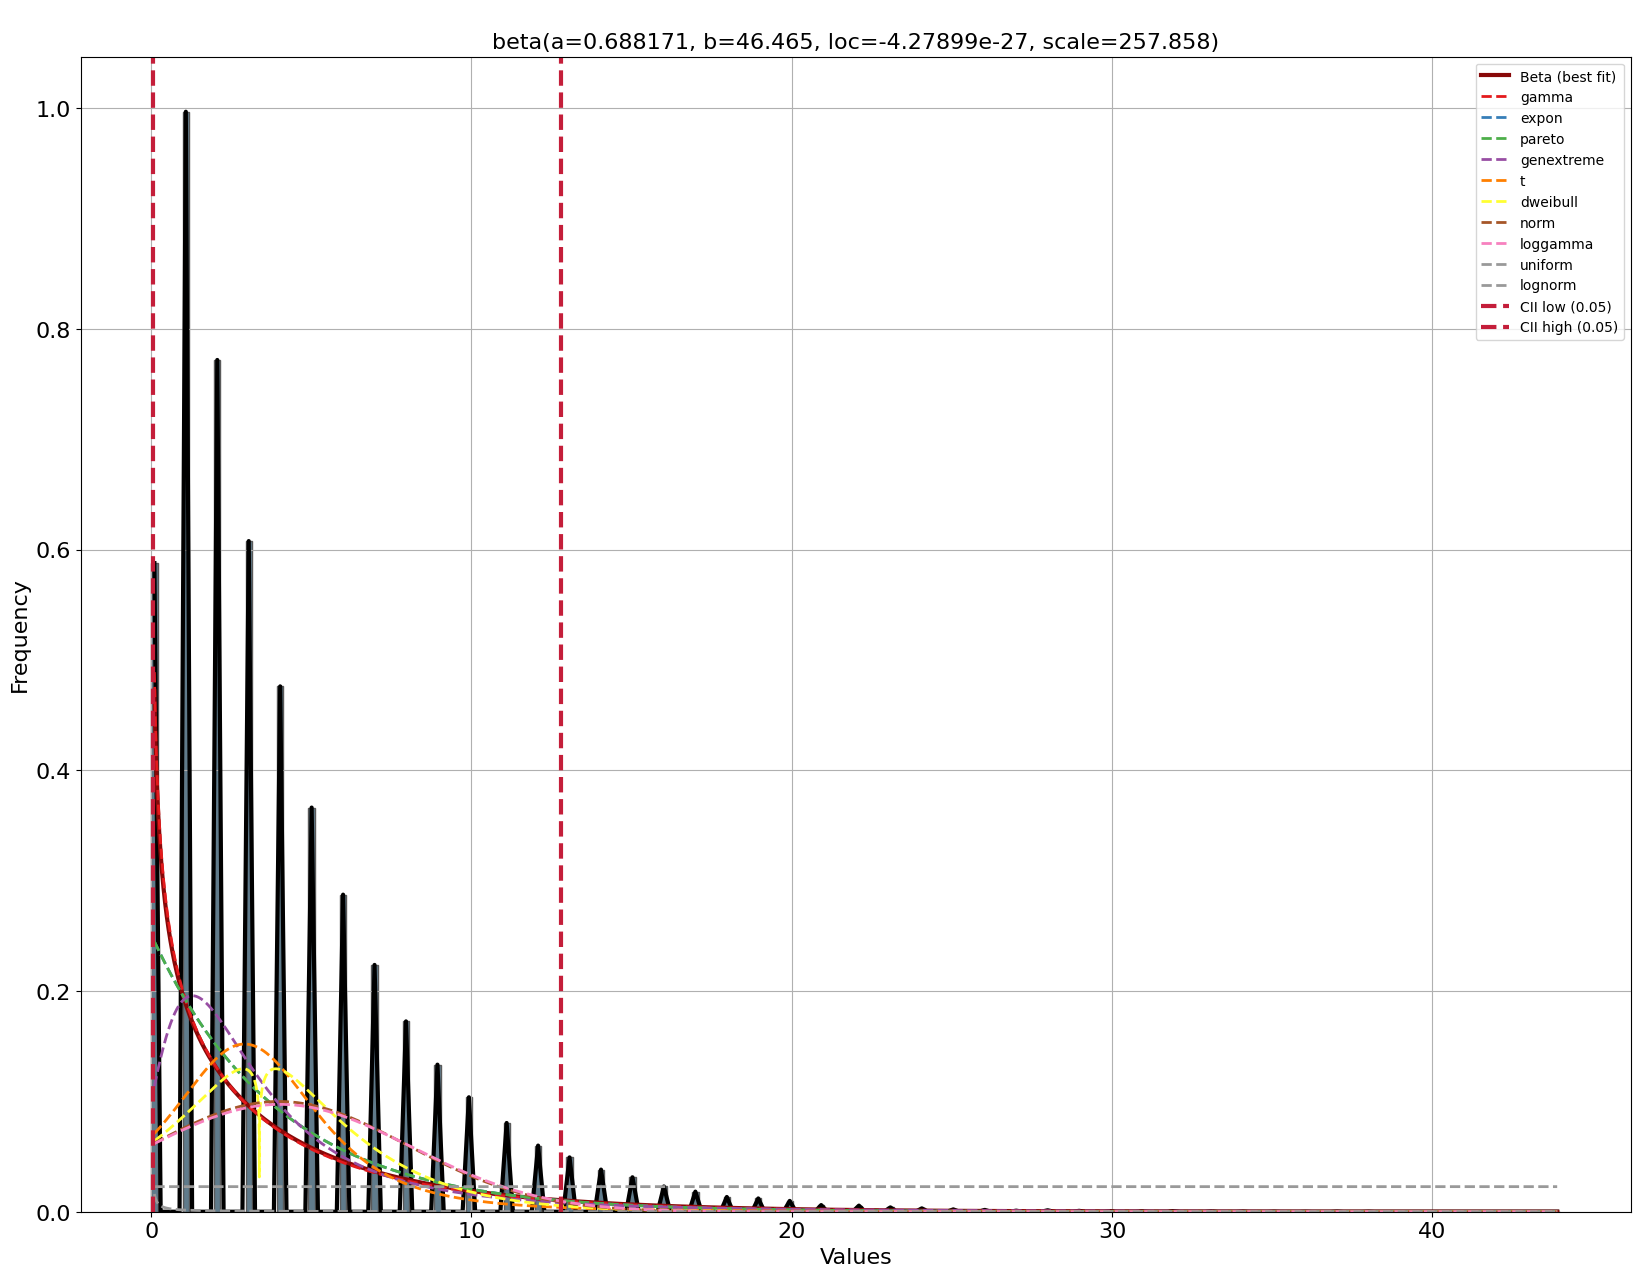

In [ ]:
# PDF with all the distributions overlaid
p, _ = dfit_iat.plot(n_top=11, figsize=(7, 4))
p.show()

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nbeta(a=0.688171, b=46.465, loc=-4.27899e-27, scale=257.858)'}, xlabel='Values', ylabel='Frequency'>)

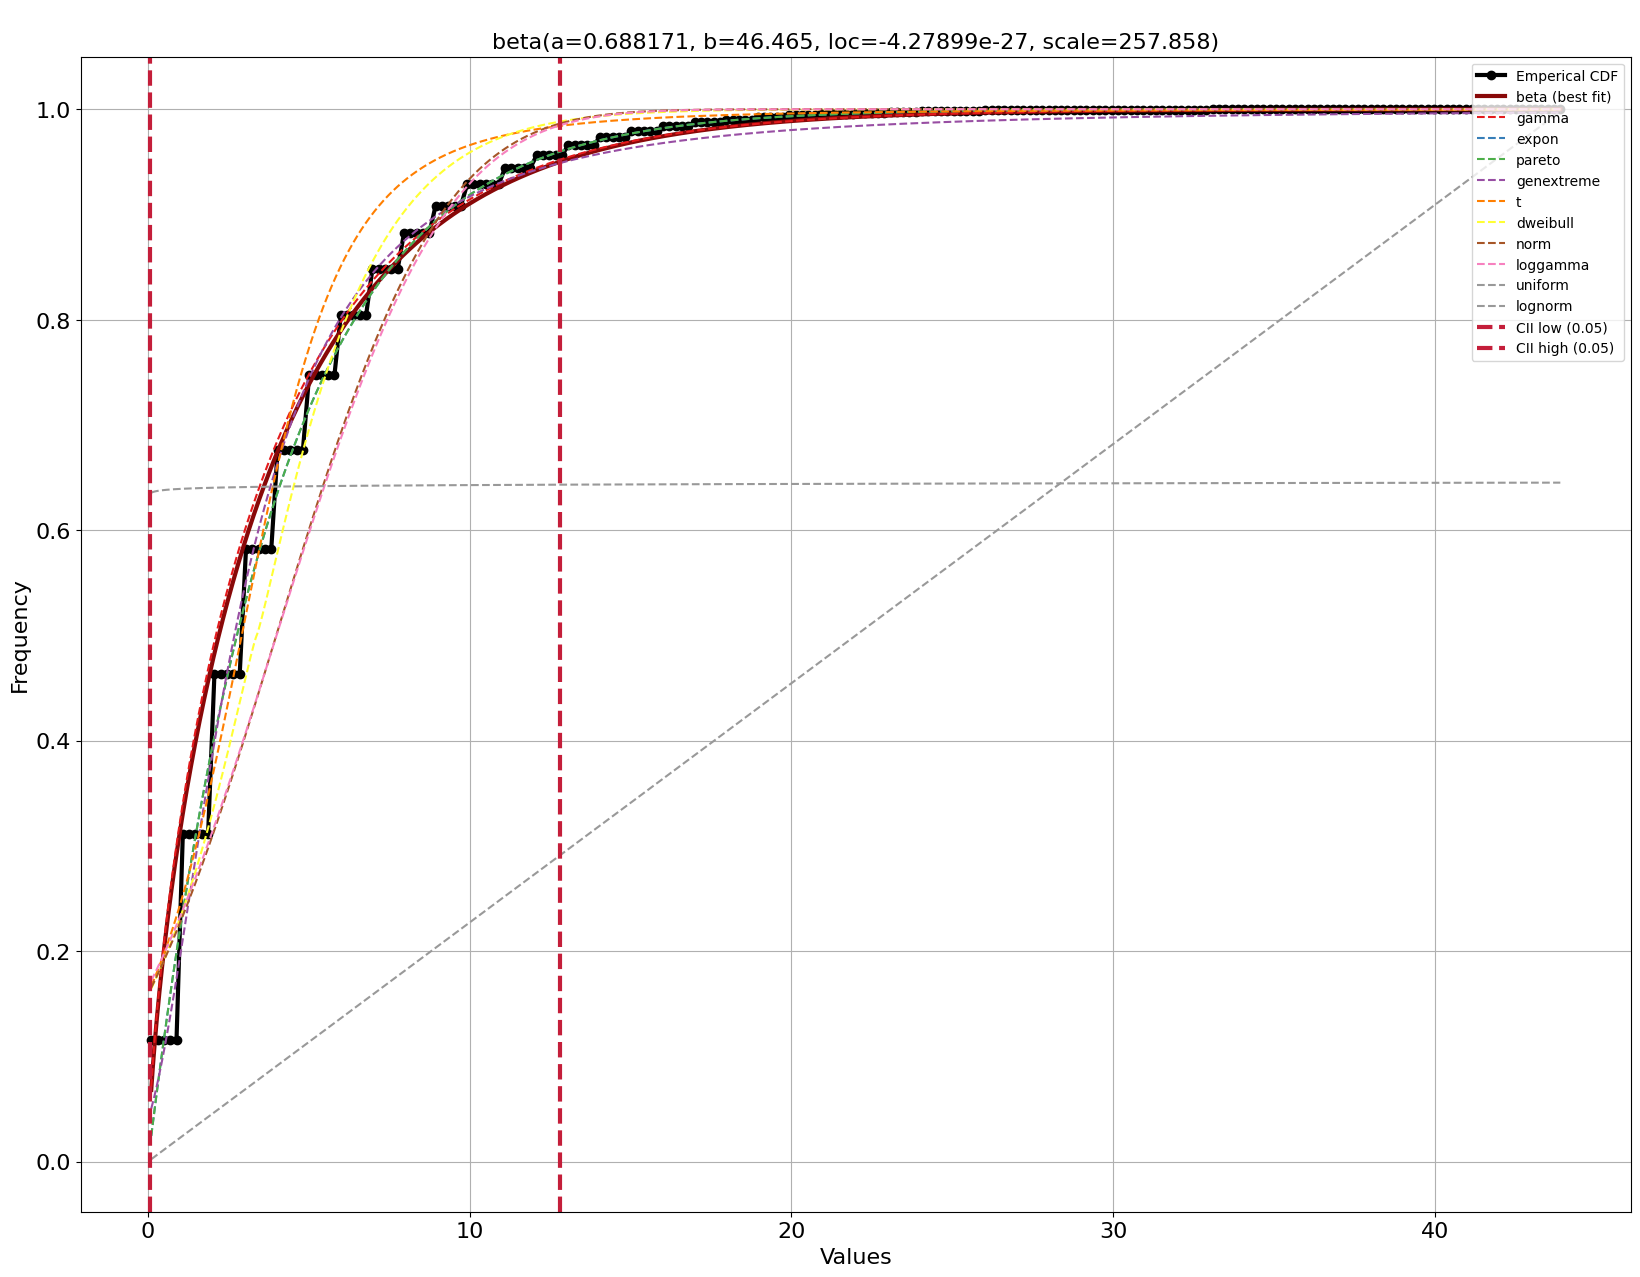

In [ ]:
# CDF with all the distributions overlaid
p, _ = dfit_iat.plot(chart="cdf", n_top=11, figsize=(7, 4))
p.show()

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': 'QQ-plot\nbeta(a=0.688171, b=46.465, loc=-4.27899e-27, scale=257.858)'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>)

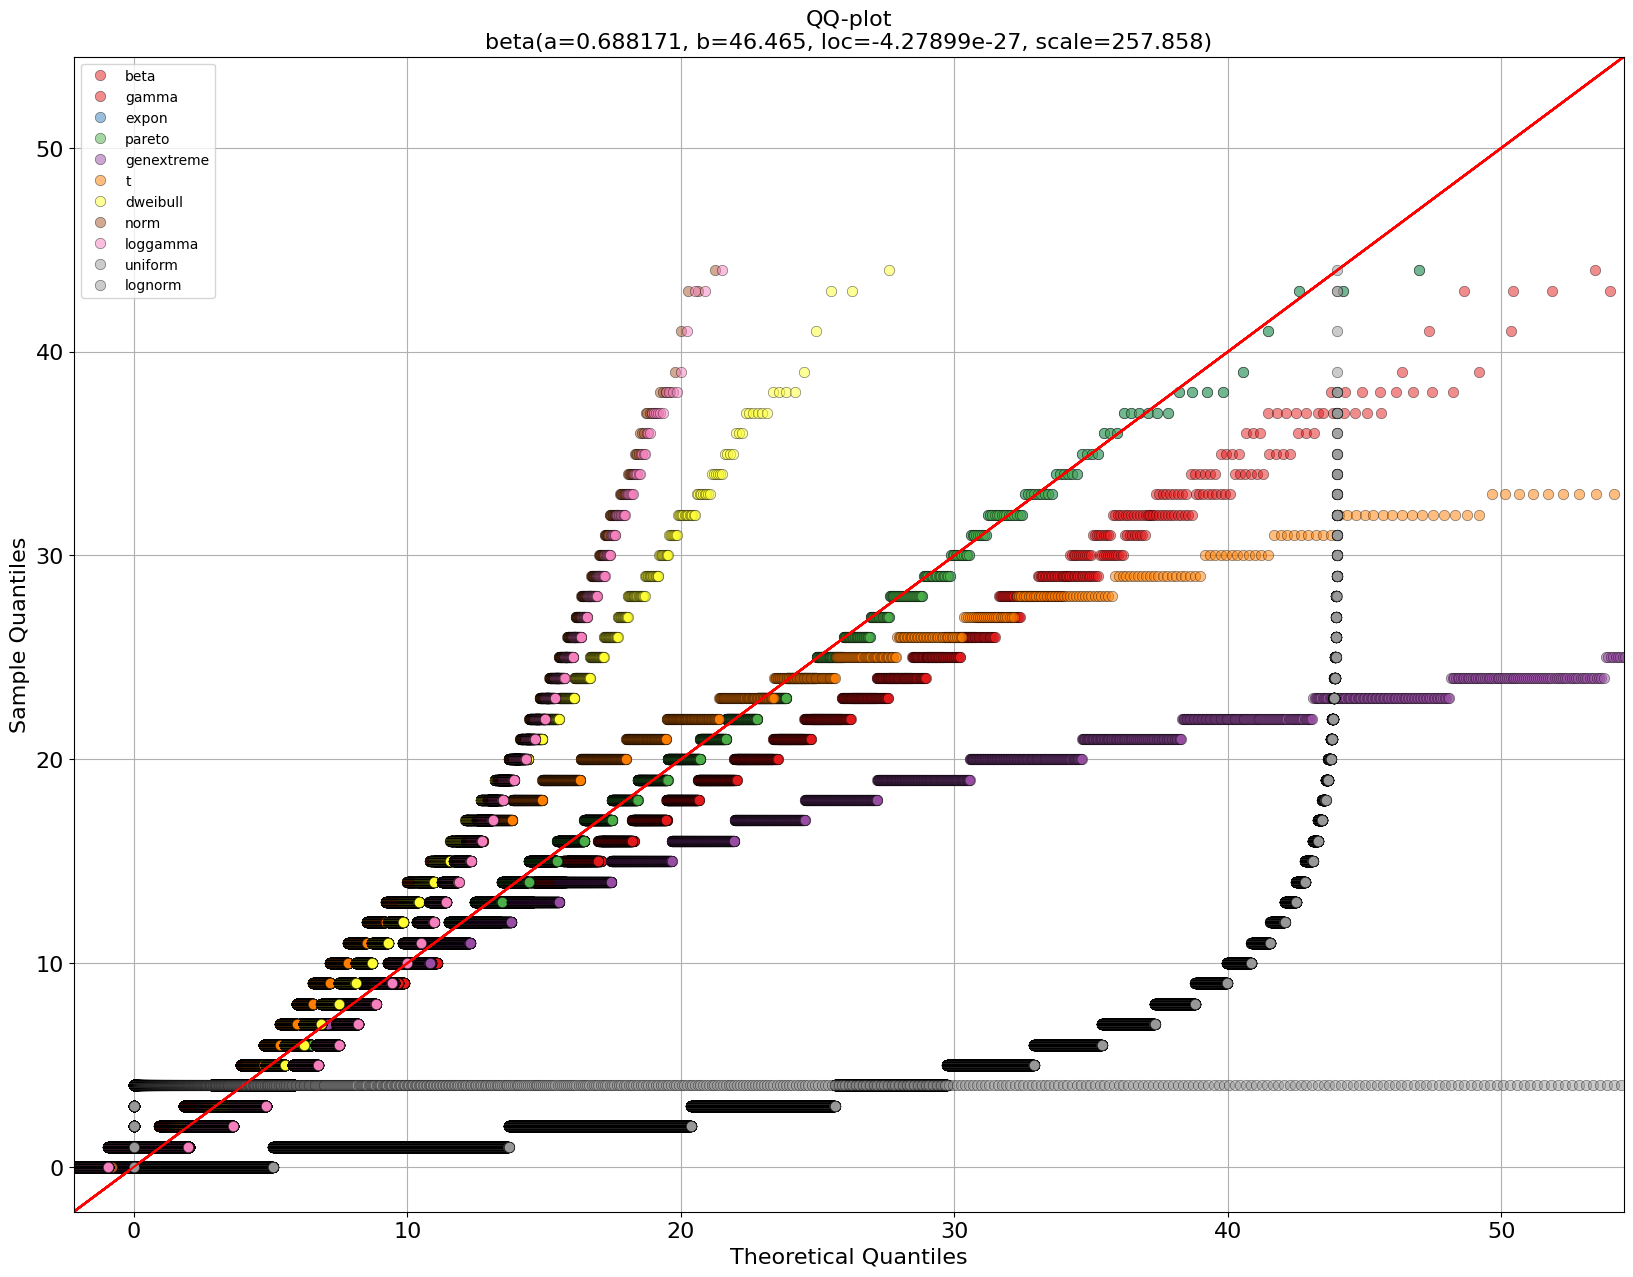

In [ ]:
# QQ plot with all distributions overlaid
p, _ = dfit_iat.qqplot(data["iat_mins"].dropna(), n_top=11, figsize=(7, 4))
p.show()

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Beta (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

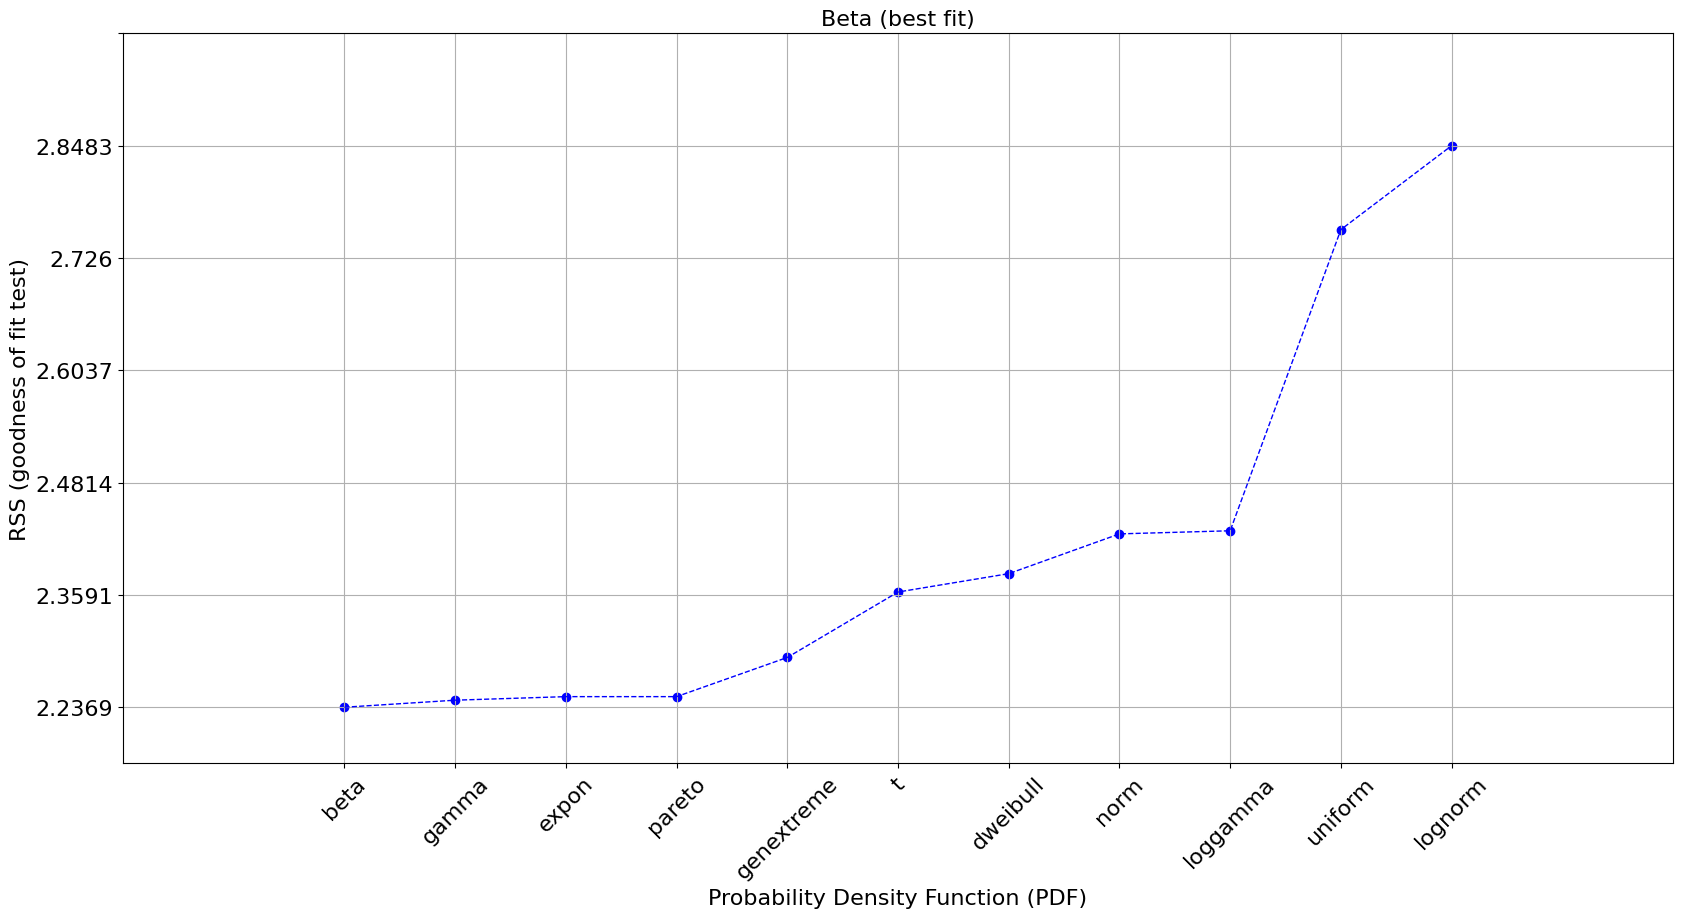

In [ ]:
# Summary plot using the RSS
p, _ = dfit_iat.plot_summary(figsize=(7, 4))
p.show()

[15-05-2025 14:08:32] [distfit.distfit] fit
[15-05-2025 14:08:32] [distfit.distfit] transform
[15-05-2025 14:08:32] [distfit.distfit] [expon] [0.00 sec] [RSS: 2.2484] [loc=0.000 scale=3.984]
[15-05-2025 14:08:32] [distfit.distfit] [expon] [0.00 sec] [RSS: 2.2484] [loc=0.000 scale=3.984]
[15-05-2025 14:08:32] [distfit.distfit] Compute confidence intervals [parametric]
[15-05-2025 14:08:32] [distfit.distfit] Create pdf plot for the parametric method.
[15-05-2025 14:08:32] [distfit.distfit] Estimated distribution: Expon(loc:0.000000, scale:3.984361)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nexpon(loc=0, scale=3.98436)'}, xlabel='Values', ylabel='Frequency'>)

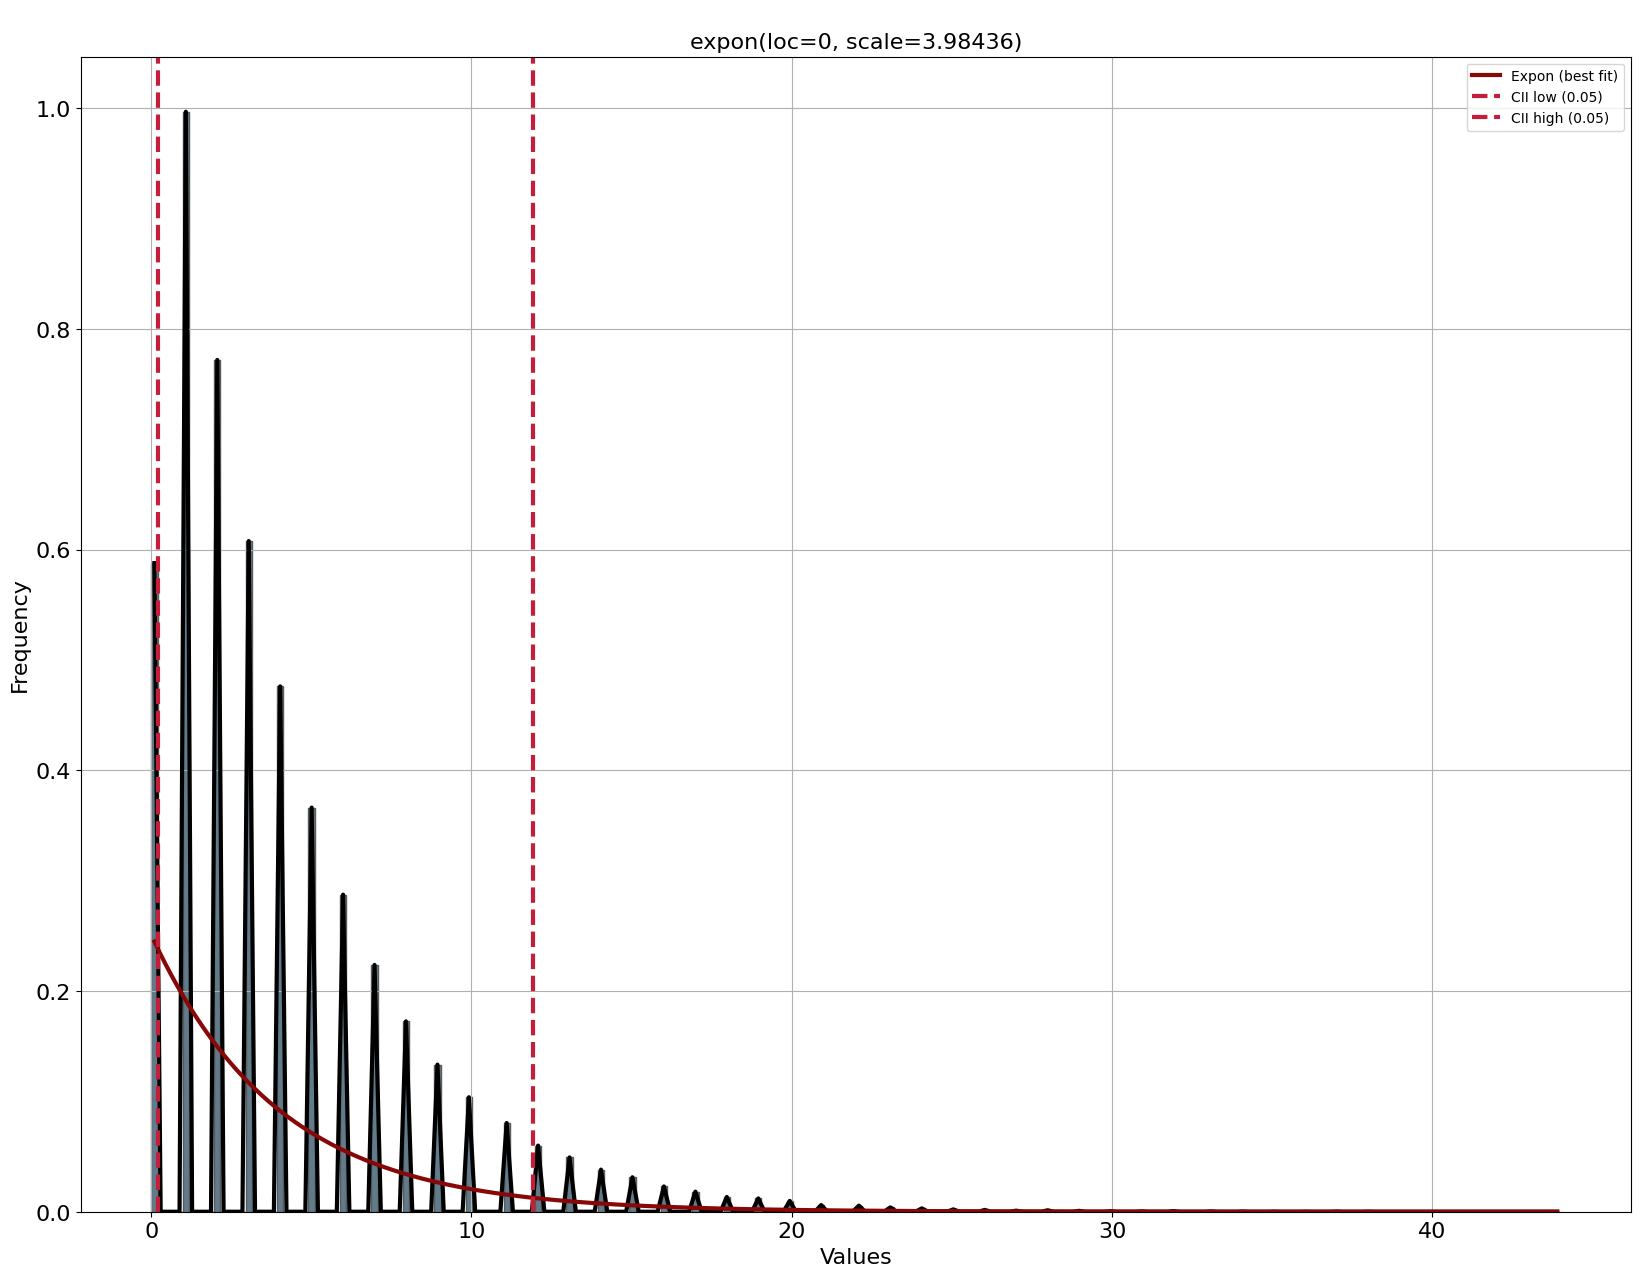

In [25]:
# To create a plot with a specific distribution overlaid...
dfit = distfit(distr="expon")
_ = dfit.fit_transform(data["iat_mins"].dropna())
p, _ = dfit.plot(figsize=(7, 4))
p.show()

## Chosen distributions

It's good to have an idea of good likely distributions before testing a few. You can either do this directly with `scipy.stats`, or use a tool like `distfit`. This tool has the benefit of being able to run a whole panel of different distributions easily and plot results.

In this case, manually we found exponential to be best. With `distfit`, there were a few distributions that were all very low scores (pareto, expon, genextreme). Choosing between these...

* Exponential - simple, wide application, good for context, fewer parameters
* Generalised pareto - useful if data has heavier tail (not the case here)
* Generalised extreme value - more complex, spefically designed for modeling maximum values or extreme events

As such, **exponential** seems a good choice for inter-arrival and service times.

## Parameters

The exponential distribution is defined by a single parameter, but this parameter can be expressed in two ways - as the:

* **Mean** (also called the **scale**) - this is just your sample mean.
* **Rate** (also called **lambda** λ) - this is calculated as `1 / mean`.

We will use the `Exponential` class from `sim-tools`, which uses the `numpy.random.exponential()` function. That accepts the **scale** parameter, so we just need to calculate the sample mean.

Mean:

* Inter-arrival time: 4 minutes.
* Service time: 10 minutes.

In [26]:
print(data["iat_mins"].dropna().mean())
print(data["service_mins"].dropna().mean())

3.9843611416442406
9.991570393280572
